# Physics-informed neural network (PINN)

Às vezes o termo "PINN" é usado como um termo genérico representativo de toda a disciplina de modelos de rede-neural híbridos. No presente contexto dessa apresentação, PINN refere-se a redes neurais usadas para resolver equações diferenciais codificando as equações relevantes na '*loss function*' da rede neural.

$$\mathcal{L} = \sum(y_i - \hat{y}_i)^2 + \alpha\sum f_{phys}(x_i)$$

In [1]:
# importing basic libs
import os
import sys

# setting up code to run in google colab
git_repo_url = "https://github.com/SarvTex/june_sciml_workshop.git"
repo_name = "june_sciml_workshop"

if 'google.colab' in sys.modules:
    # Google colab setup
    print("> Code running in Colab env ===")

    if not repo_name in os.getcwd().split(os.sep) and not repo_name in os.listdir():
        print("> Cloning repo (dataset) ===")
        !git clone {git_repo_url}
    else:
      print("> Repo already cloned ===")

    if repo_name in os.listdir():
        os.chdir(repo_name)
    print(f"> Currently in correct folder ({os.getcwd()}) ===")

else:
    # Running locally setup
    print("> Running locally. Assuming correct folder structure ===")

!ls

> Running locally. Assuming correct folder structure ===
01_pinnModel.ipynb		13_pybammCreateData.ipynb  explore_data.ipynb
02_udeModel.ipynb		README.md		   imgs
11_pybammCompareModels.ipynb	data			   test.ipynb
12_pybammAgingExperiment.ipynb	enviroment.yml


### Modelo básico
Modelo básico que resolve o seguinte sistema de equações:
$$\begin{align}
y'(x) &= \beta\cdot y(x) \\
y(0) &= 1
\end{align}$$

In [2]:
# Import libs

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# set up data
x = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)
data_x = torch.tensor([0, 0.25, 0.5, 0.75, 1]).reshape(-1, 1)
data_y = torch.exp(2 * data_x)
data_y = data_y + torch.randn(data_x.shape) * 0.01
data_y

tensor([[1.0060],
        [1.6536],
        [2.7329],
        [4.4783],
        [7.3827]])

In [4]:
# init model
mlp = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
)

beta = torch.randn(1, requires_grad=True)
beta

tensor([-0.6568], requires_grad=True)

In [5]:
optimizer = optim.Adam(list(mlp.parameters()) + [beta], lr=0.01)

def dy_dx(y, x):
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

In [6]:
# train loop
losses = []

for i in range(500):
    y = mlp.forward(x)
    y_p = dy_dx(y, x)

    residual_ode = y_p - beta * y

    residual_int = y[0] - 1

    data_pred = mlp.forward(data_x)
    residual_data = data_pred - data_y

    loss = (residual_data**2).mean() + (residual_ode**2).mean() + residual_int**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().numpy()[0])

    if i % 20 == 0:
        print(
            "Epoch %3d: Current loss: %.2e \t beta: %.2f"
            % (i, losses[-1], beta.detach().numpy()[0])
        )

Epoch   0: Current loss: 1.67e+01 	 beta: -0.65
Epoch  20: Current loss: 9.21e+00 	 beta: -0.45
Epoch  40: Current loss: 8.11e+00 	 beta: -0.25
Epoch  60: Current loss: 6.98e+00 	 beta: -0.04
Epoch  80: Current loss: 5.83e+00 	 beta: 0.17
Epoch 100: Current loss: 4.66e+00 	 beta: 0.38
Epoch 120: Current loss: 3.59e+00 	 beta: 0.58
Epoch 140: Current loss: 2.68e+00 	 beta: 0.77
Epoch 160: Current loss: 1.94e+00 	 beta: 0.95
Epoch 180: Current loss: 1.37e+00 	 beta: 1.10
Epoch 200: Current loss: 9.52e-01 	 beta: 1.24
Epoch 220: Current loss: 6.55e-01 	 beta: 1.36
Epoch 240: Current loss: 4.50e-01 	 beta: 1.46
Epoch 260: Current loss: 3.10e-01 	 beta: 1.54
Epoch 280: Current loss: 2.14e-01 	 beta: 1.62
Epoch 300: Current loss: 1.48e-01 	 beta: 1.68
Epoch 320: Current loss: 1.02e-01 	 beta: 1.73
Epoch 340: Current loss: 7.18e-02 	 beta: 1.77
Epoch 360: Current loss: 5.00e-02 	 beta: 1.81
Epoch 380: Current loss: 3.41e-02 	 beta: 1.84
Epoch 400: Current loss: 2.35e-02 	 beta: 1.87
Epoch 420

In [7]:
x_test = torch.linspace(0, 1, 31).reshape(-1, 1)
exact = torch.exp(2 * x_test)
predict = mlp.forward(x_test).detach().numpy()
error = exact - predict

MAE = torch.abs(error).mean()

print("Mean Absolute Error: %.2e" % MAE)

Mean Absolute Error: 1.72e-02


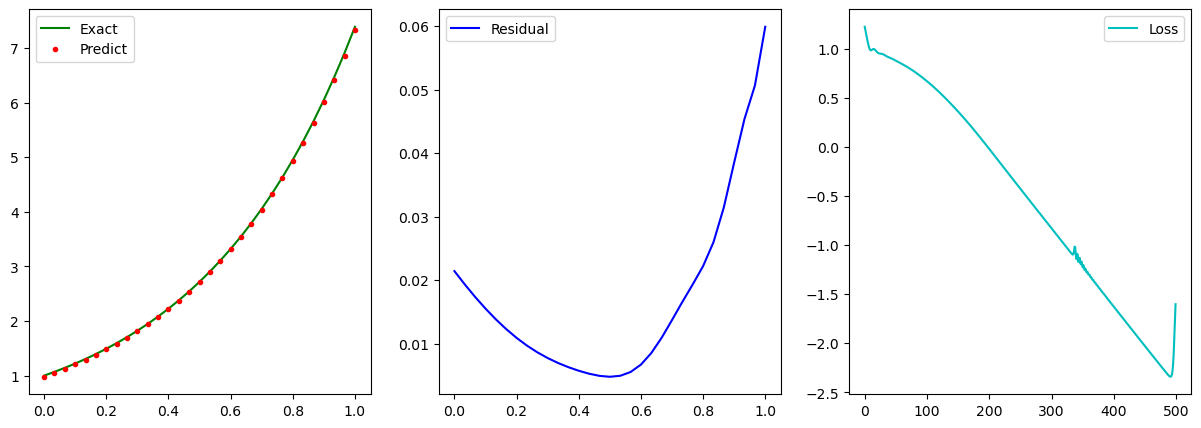

In [8]:
# plot some figs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(x_test, exact, "g-", label="Exact")
axs[0].plot(x_test, predict, "r.", label="Predict")

axs[1].plot(x_test, error, "b", label="Residual")

axs[2].plot(np.log10(losses), "c", label="Loss")

for ax in axs:
    ax.legend()